In [44]:
import logging

import matplotlib.pyplot as plt
import numpy as np
import petab

import pypesto
import pypesto.optimize as optimize
import pypesto.petab
import pypesto.sample as sample
import pypesto.visualize as visualize
import amici
from pypesto.store import read_from_hdf5, save_to_hdf5

In [47]:

# log diagnostics
logger = logging.getLogger("pypesto.sample.diagnostics")
logger.setLevel(logging.INFO)
logger.addHandler(logging.StreamHandler())
# import to petab
petab_problem = petab.Problem.from_yaml(
    "/home/zarifeh/Desktop/Test/ResultsOct12/EGFR/EGFR.yaml"
)
# import to pypesto
importer = pypesto.petab.PetabImporter(petab_problem)
# create problem
problem = importer.create_problem()

#########################
model = importer.create_model(verbose=False)
##########################


Using existing amici model in folder /home/zarifeh/Desktop/amici_models/EGFR_Kholodenko_Step4.
Using existing amici model in folder /home/zarifeh/Desktop/amici_models/EGFR_Kholodenko_Step4.


In [48]:
fn = "/home/zarifeh/Desktop/2022_18_10_09_45_42_optimize_result_bacc2c5d06a45517.h5"
pypesto_result = read_from_hdf5.read_result(fn)
mle = pypesto_result.optimize_result.list[0]['x'][0:5]
print(mle)


This problem is not to be used without a separately created objective.
Loading the profiling result failed. It is highly likely that no profiling result exists within /home/zarifeh/Desktop/2022_18_10_09_45_42_optimize_result_bacc2c5d06a45517.h5.
Loading the sampling result failed. It is highly likely that no sampling result exists within /home/zarifeh/Desktop/2022_18_10_09_45_42_optimize_result_bacc2c5d06a45517.h5.


[ 10.92641416   4.76199326  11.         -13.25568753  -1.85466088]


In [ ]:

sampler = sample.AdaptiveParallelTemperingSampler(
    internal_sampler=sample.AdaptiveMetropolisSampler(), n_chains=3
)

result = sample.sample(
    problem,
    n_samples=10000,
    sampler=sampler,
    x0=mle,
)
elapsed_time = result.sample_result.time
print(f"Elapsed time: {round(elapsed_time,2)}")


alpha = [99, 95, 90]



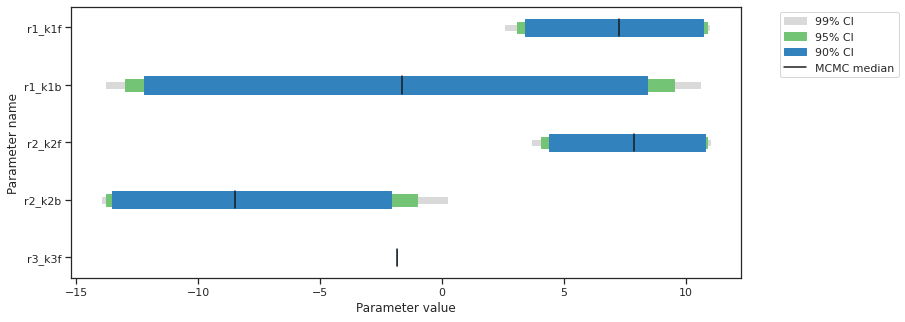

In [51]:
ax = visualize.sampling_parameter_cis(result, alpha=alpha, size=(12, 5))


array([[<AxesSubplot:xlabel='r1_k1f', ylabel='Density'>,
        <AxesSubplot:xlabel='r1_k1b', ylabel='Density'>,
        <AxesSubplot:xlabel='r2_k2f', ylabel='Density'>],
       [<AxesSubplot:xlabel='r2_k2b', ylabel='Density'>,
        <AxesSubplot:xlabel='r3_k3f', ylabel='Density'>, <AxesSubplot:>]],
      dtype=object)

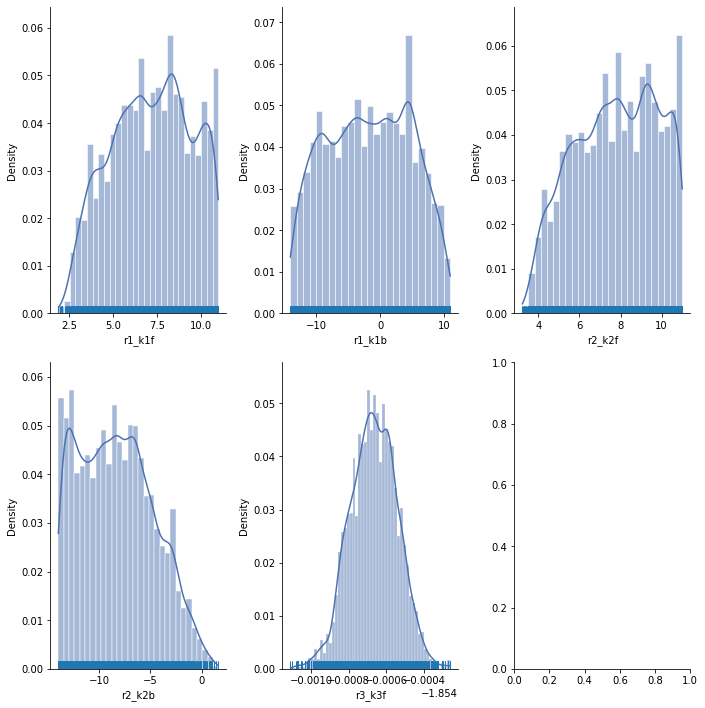

In [50]:
pypesto.visualize.sampling_1d_marginals(result, size=(10, 10))


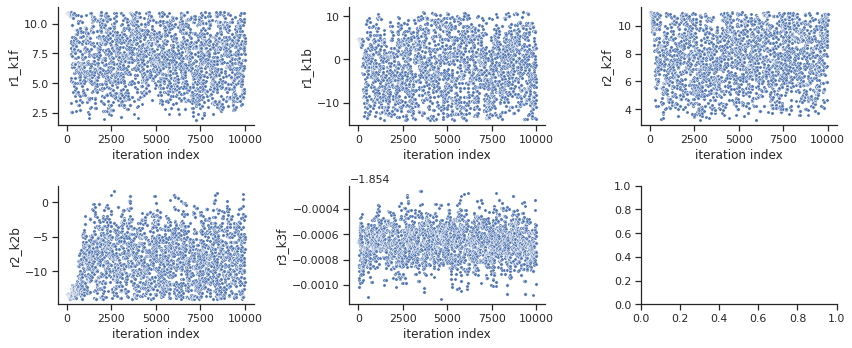

In [81]:
ax = visualize.sampling_parameter_traces(
    result, use_problem_bounds=False, size=(12, 5)
)

<AxesSubplot:xlabel='iteration index', ylabel='log-posterior'>

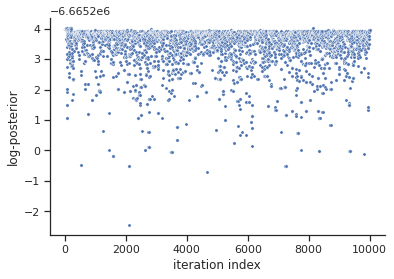

In [82]:
visualize.sampling_fval_traces(result)

Text(0, 0.5, 'Log Posterior')

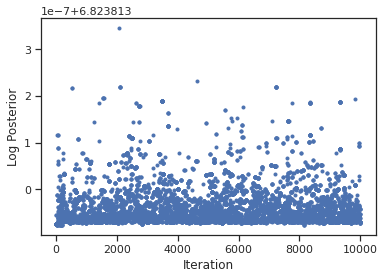

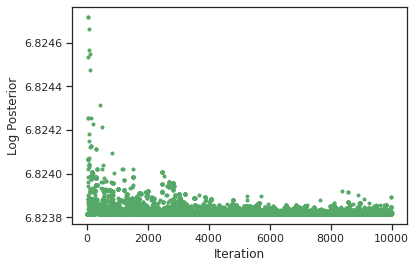

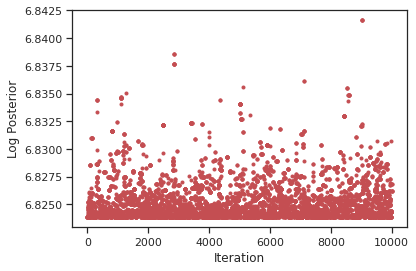

In [87]:
plt.plot(np.log10(result.sample_result.trace_neglogpost[0]), 'b.')
plt.xlabel("Iteration")
plt.ylabel("Log Posterior")
plt.figure()
plt.plot(np.log10(result.sample_result.trace_neglogpost[1]), 'g.')
plt.xlabel("Iteration")
plt.ylabel("Log Posterior")
plt.figure()
plt.plot(np.log10(result.sample_result.trace_neglogpost[2]), 'r.')
plt.xlabel("Iteration")
plt.ylabel("Log Posterior")


### AZ PAPER

In [92]:


from pypesto.C import AMICI_STATUS, AMICI_T, AMICI_X, AMICI_Y
from pypesto.predict import AmiciPredictor
from pypesto.C import EnsembleType
import numpy as np
from pypesto.ensemble import Ensemble
# such that the output is compatible with the next steps.
def post_processor(amici_outputs, output_type, output_ids):
    outputs = [
        amici_output[output_type]
        if amici_output[AMICI_STATUS] == 0
        else np.full((len(amici_output[AMICI_T]), len(output_ids)), np.nan)
        for amici_output in amici_outputs
    ]
    return outputs


# Setup post-processors for both states and observables.
from functools import partial

amici_objective = result.problem.objective
state_ids = amici_objective.amici_model.getStateIds()
observable_ids = amici_objective.amici_model.getObservableIds()
post_processor_x = partial(
    post_processor,
    output_type=AMICI_X,
    output_ids=state_ids,
)
post_processor_y = partial(
    post_processor,
    output_type=AMICI_Y,
    output_ids=observable_ids,
)

# Create pyPESTO predictors for states and observables
predictor_x = AmiciPredictor(
    amici_objective,
    post_processor=post_processor_x,
    output_ids=state_ids,
)
predictor_y = AmiciPredictor(
    amici_objective,
    post_processor=post_processor_y,
    output_ids=observable_ids,
)


In [97]:

from pypesto.C import EnsembleType
from pypesto.ensemble import Ensemble

# corresponds to only the estimated parameters
x_names = result.problem.get_reduced_vector(result.problem.x_names[0:5])

# Create the ensemble with the MCMC chain from parallel tempering with the real temperature.
ensemble = Ensemble.from_sample(
    result,
    chain_slice=slice(
        None, None, 2
    ),  # Optional argument: only use every second vector in the chain.
    x_names=x_names[0:5],
    ensemble_type=EnsembleType.sample,
    lower_bound=result.problem.lb,
    upper_bound=result.problem.ub,
)

In [98]:
from pypesto.engine import MultiThreadEngine

# Currently, parallelization of predictions is supported with the
# `pypesto.engine.MultiProcessEngine` and `pypesto.engine.MultiThreadEngine`
# engines. If no engine is specified, the `pypesto.engine.SingleCoreEngine`
# engine is used.
engine = MultiThreadEngine()

ensemble_prediction = ensemble.predict(
    predictor_x, prediction_id=AMICI_X, engine=engine
)

Engine set up to use up to 8 processes in total. The number was automatically determined and might not be appropriate on some systems.
Performing parallel task execution on 8 threads.
  0%|          | 0/8 [00:00<?, ?it/s]Executing task 0.
Executing task 1.
Executing task 2.
Executing task 3.
100%|██████████| 8/8 [00:00<00:00, 560.55it/s]Executing task 4.
Executing task 5.

Executing task 6.
Executing task 7.


In [99]:
# Create the ensemble with the MCMC chain from parallel tempering with the real temperature.
ensemble = Ensemble.from_sample(
    result,
    x_names=x_names,
    ensemble_type=EnsembleType.sample,
    lower_bound=result.problem.lb,
    upper_bound=result.problem.ub,
)

ensemble_prediction = ensemble.predict(
    predictor_y, prediction_id=AMICI_Y, engine=engine
)

Performing parallel task execution on 8 threads.
  0%|          | 0/8 [00:00<?, ?it/s]Executing task 0.
Executing task 1.
Executing task 2.
Executing task 3.
Executing task 4.
100%|██████████| 8/8 [00:00<00:00, 527.96it/s]Executing task 5.

Executing task 6.
Executing task 7.


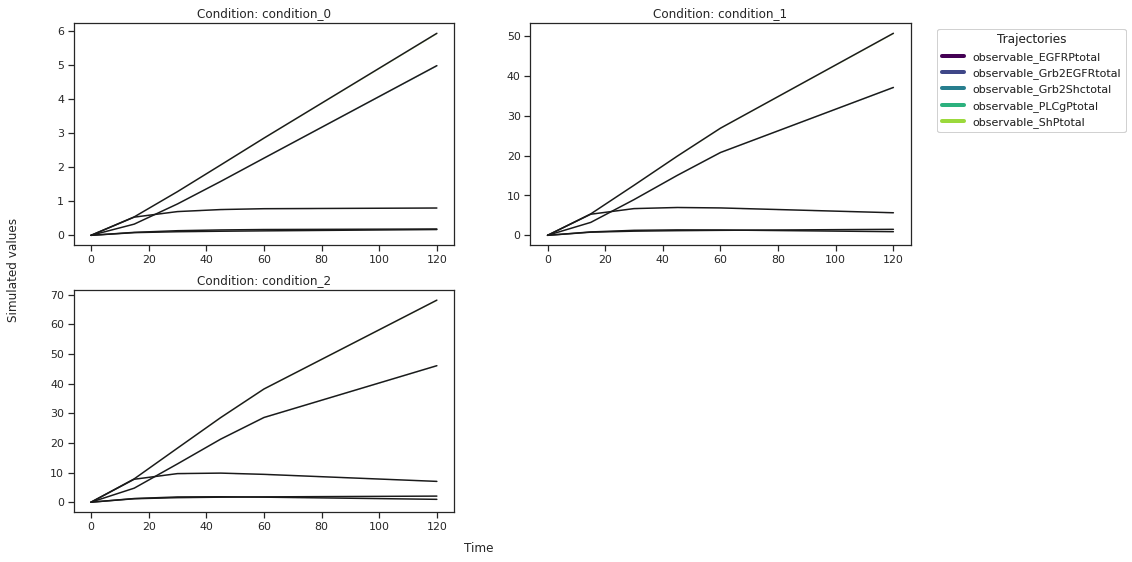

In [100]:
from pypesto.C import CONDITION, OUTPUT
credibility_interval_levels = [90, 95, 99]
ax = visualize.sampling_prediction_trajectories(
    ensemble_prediction,
    levels=credibility_interval_levels,
    size=(15, 9),
    axis_label_padding=60,
    groupby=CONDITION,
)

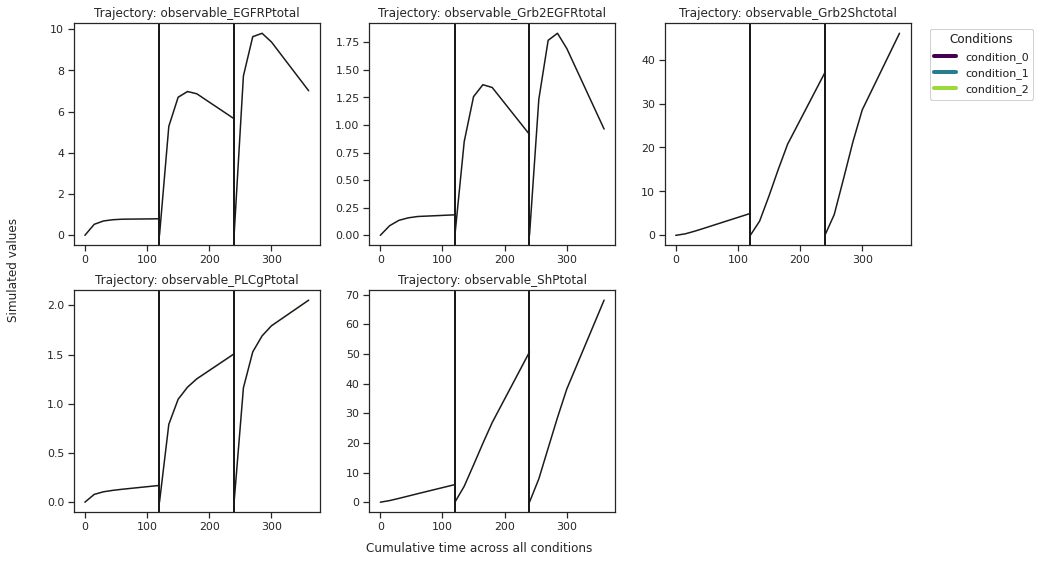

In [102]:


ax = visualize.sampling_prediction_trajectories(
    ensemble_prediction,
    levels=credibility_interval_levels,
    size=(15, 9),
    axis_label_padding=60,
    groupby=OUTPUT,
    reverse_opacities=True,
)



Performing parallel task execution on 8 threads.
  0%|          | 0/8 [00:00<?, ?it/s]Executing task 0.
Executing task 1.
Executing task 2.
100%|██████████| 8/8 [00:00<00:00, 909.06it/s]
Executing task 3.
Executing task 4.
Executing task 5.
Executing task 6.
Executing task 7.


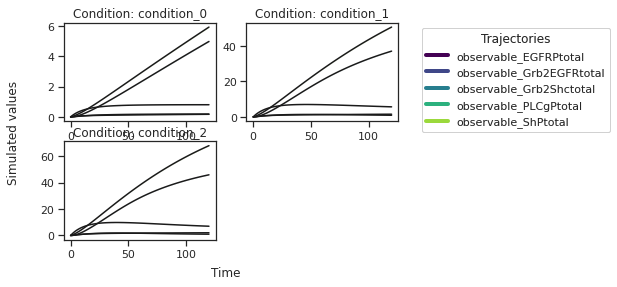

In [110]:
# Create a custom objective with new output timepoints.
timepoints = [np.linspace(0, 120, 121), np.linspace(0, 120, 121), np.linspace(0, 120, 121)]
amici_objective_custom = amici_objective.set_custom_timepoints(
    timepoints=timepoints
)

# Create an observable predictor with the custom objective.
predictor_y_custom = AmiciPredictor(
    amici_objective_custom,
    post_processor=post_processor_y,
    output_ids=observable_ids,
)

# Predict then plot.
ensemble_prediction = ensemble.predict(
    predictor_y_custom, prediction_id=AMICI_Y, engine=engine
)


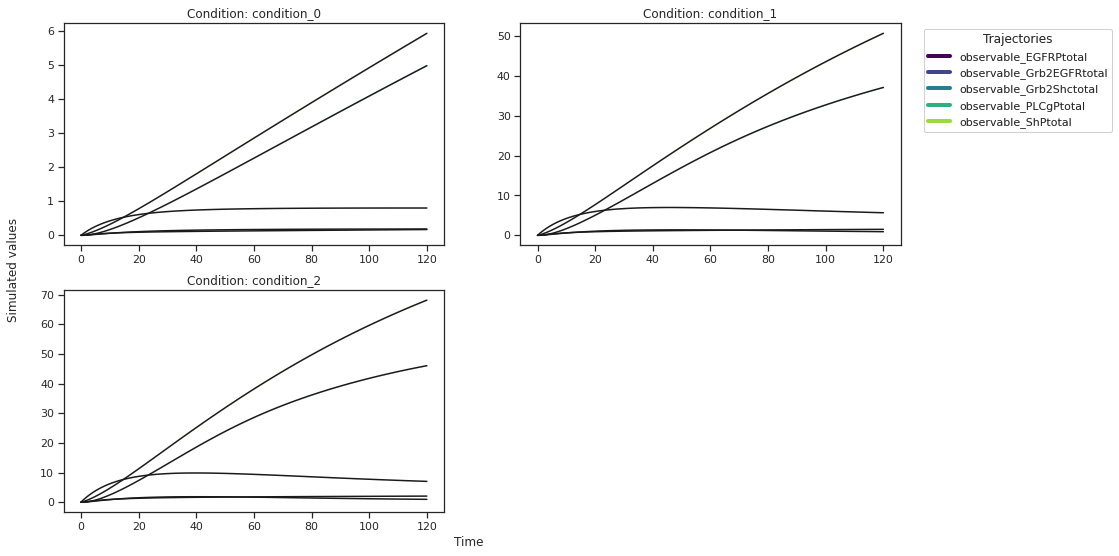

In [111]:
ax = visualize.sampling_prediction_trajectories(
    ensemble_prediction,
    levels=credibility_interval_levels,
    groupby=CONDITION,
    size=(15, 9))